# Introduction: Manual Feature Engineering

If you are new to this competition, I highly suggest checking out [this notebook](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction/) to get started.

In this notebook, we will explore making features by hand for the Home Credit Default Risk competition. In an earlier notebook, we used only the `application` data in order to build a model. The best model we made from this data achieved a score on the leaderboard around 0.74. In order to better this score, we will have to include more information from the other dataframes. Here, we will look at using information from the `bureau` and `bureau_balance` data. The definitions of these data files are:

* bureau: information about client's previous loans with other financial institutions reported to Home Credit. Each previous loan has its own row.
* bureau_balance: monthly information about the previous loans. Each month has its own row.

Manual feature engineering can be a tedious process (which is why we use automated feature engineering with featuretools!) and often relies on domain expertise. Since I have limited domain knowledge of loans and what makes a person likely to default, I will instead concentrate of getting as much info as possible into the final training dataframe. The idea is that the model will then pick up on which features are important rather than us having to decide that. Basically, our approach is to make as many features as possible and then give them all to the model to use! Later, we can perform feature reduction using the feature importances from the model or other techniques such as PCA. 

The process of manual feature engineering will involve plenty of Pandas code, a little patience, and a lot of great practice manipulation data. Even though automated feature engineering tools are starting to be made available, feature engineering will still have to be done using plenty of data wrangling for a little while longer. 

In [6]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

## Example: Counts of a client's previous loans

To illustrate the general process of manual feature engineering, we will first simply get the count of a client's previous loans at other financial institutions. This requires a number of Pandas operations we will make heavy use of throughout the notebook:

* `groupby`: group a dataframe by a column. In this case we will group by the unique client, the `SK_ID_CURR` column
* `agg`: perform a calculation on the grouped data such as taking the mean of columns. We can either call the function directly (`grouped_df.mean()`) or use the `agg` function together with a list of transforms (`grouped_df.agg([mean, max, min, sum])`)
* `merge`: match the aggregated statistics to the appropriate client. We need to merge the original training data with the calculated stats on the `SK_ID_CURR` column which will insert `NaN` in any cell for which the client does not have the corresponding statistic

We also use the (`rename`) function quite a bit specifying the columns to be renamed as a dictionary. This is useful in order to keep track of the new variables we create.

This might seem like a lot, which is why we'll eventually write a function to do this process for us. Let's take a look at implementing this by hand first. 

In [ ]:
# Read in bureau
bureau = pd.read_csv('../input/bureau.csv')
bureau.head()

In [ ]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

In [ ]:
# Join to the training dataframe
train = pd.read_csv('../input/application_train.csv')
train = train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

# Fill the missing values with 0 
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

Scroll all the way to the right to see the new column. 

## Assessing Usefulness of New Variable with r value

To determine if the new variable is useful, we can calculate the Pearson Correlation Coefficient (r-value) between this variable and the target. This measures the strength of a linear relationship between two variables and ranges from -1 (perfectly negatively linear) to +1 (perfectly positively linear). The r-value is not best measure of the "usefulness" of a new variable, but it can give a first approximation of whether a variable will be helpful to a machine learning model. The larger the r-value of a variable with respect to the target, the more a change in this variable is likely to affect the value of the target. Therefore, we look for the variables with the greatest absolute value r-value relative to the target.

We can also visually inspect a relationship with the target using the Kernel Density Estimate (KDE) plot. 

### Kernel Density Estimate Plots

The kernel density estimate plot shows the distribution of a single variable (think of it as a smoothed histogram). To see the different in distributions dependent on the value of a categorical variable, we can color the distributions differently according to the category. For example, we can show the kernel density estimate of the `previous_loan_count` colored by whether the `TARGET` = 1 or 0. The resulting KDE will show any significant differences in the distribution of the variable between people who did not repay their loan (`TARGET == 1`) and the people who did (`TARGET == 0`). This can serve as an indicator of whether a variable will be 'relevant' to a machine learning model. 

We will put this plotting functionality in a function to re-use for any variable. 

In [ ]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.ix[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.ix[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.ix[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)
    

We can test this function using the `EXT_SOURCE_3` variable which we [found to be one of the most important variables ](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction) according to a Random Forest and Gradient Boosting Machine. 

In [ ]:
kde_target('EXT_SOURCE_3', train)

Now for the new variable we just made, the number of previous loans at other institutions.

In [ ]:
kde_target('previous_loan_counts', train)

From this it's difficult to tell if this variable will be important. The correlation coefficient is extremely weak and there is almost no noticeable difference in the distributions. 

Let's move on to make a few more variables from the bureau dataframe. We will take the mean, min, and max of every numeric column in the bureau dataframe.

## Aggregating Numeric Columns

To account for the numeric information in the `bureau` dataframe, we can compute statistics for all the numeric columns. To do so, we `groupby` the client id, `agg` the grouped dataframe, and merge the result back into the training data. The `agg` function will only calculate the values for the numeric columns where the operation is considered valid. We will stick to using `'mean', 'max', 'min', 'sum'` but any function can be passed in here. We can even write our own function and use it in an `agg` call. 

In [ ]:
# Group by the client id, calculate aggregation statistics
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
bureau_agg.head()

We need to create new names for each of these columns. The following code makes new names by appending the stat to the name. Here we have to deal with the fact that the dataframe has a multi-level index. I find these confusing and hard to work with, so I try to reduce to a single level index as quickly as possible.

In [ ]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))

In [ ]:
# Assign the list of columns names as the dataframe column names
bureau_agg.columns = columns
bureau_agg.head()

Now we simply merge with the training data as we did before.

In [ ]:
# Merge with the training data
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
train.head()

### Correlations of Aggregated Values with Target

We can calculate the correlation of all new values with the target. Again, we can use these as an approximation of the variables which may be important for modeling. 

In [ ]:
# List of new correlations
new_corrs = []

# Iterate through the columns 
for col in columns:
    # Calculate correlation with the target
    corr = train['TARGET'].corr(train[col])
    
    # Append the list as a tuple

    new_corrs.append((col, corr))

In the code below, we sort the correlations by the magnitude (absolute value) using the `sorted` Python function. We also make use of an anonymous `lambda` function, another important Python operation that is good to know. 

In [ ]:
# Sort the correlations by the absolute value
# Make sure to reverse to put the largest values at the front of list
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:15]

None of the new variables have a significant correlation with the TARGET. We can look at the KDE plot of the highest correlated variable, `bureau_DAYS_CREDIT_mean`, with the target in  in terms of absolute magnitude correlation. 

In [ ]:
kde_target('bureau_DAYS_CREDIT_mean', train)

The definition of this column is: "How many days before current application did client apply for Credit Bureau credit". My interpretation is this is the number of days that the previous loan was applied for before the application for a loan at Home Credit. Therefore, a larger negative number indicates the loan was further before the current loan application. We see an extremely weak positive relationship between the average of this variable and the target meaning that clients who applied for loans further in the past potentially are more likely to repay loans at Home Credit. With a correlation this weak though, it is just as likely to be noise as a signal. 

#### The Multiple Comparisons Problem

When we have lots of variables, we expect some of them to be correlated just by pure chance, a [problem known as multiple comparisons](https://towardsdatascience.com/the-multiple-comparisons-problem-e5573e8b9578). We can make hundreds of features, and some will turn out to be corelated with the target simply because of random noise in the data. Then, when our model trains, it may overfit to these variables because it thinks they have a relationship with the target in the training set, but this does not necessarily generalize to the test set. There are many considerations that we have to take into account when making features! 

## Function for Numeric Aggregations

Let's encapsulate all of the previous work into a function. This will allow us to compute aggregate stats for numeric columns across any dataframe. We will re-use this function when we want to apply the same operations for other dataframes.

In [ ]:
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [ ]:
bureau_agg_new = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg_new.head()

To make sure the function worked as intended, we should compare with the aggregated dataframe we constructed by hand. 

In [ ]:
bureau_agg.head()

If we go through and inspect the values, we do find that they are equivalent. We will be able to reuse this function for calculating numeric stats for other dataframes. Using functions allows for consistent results and decreases the amount of work we have to do in the future! 

### Correlation Function

Before we move on, we can also make the code to calculate correlations with the target into a function.

In [ ]:
# Function to calculate correlations with the target for a dataframe
def target_corrs(df):

    # List of correlations
    corrs = []

    # Iterate through the columns 
    for col in df.columns:
        print(col)
        # Skip the target column
        if col != 'TARGET':
            # Calculate correlation with the target
            corr = df['TARGET'].corr(df[col])

            # Append the list as a tuple
            corrs.append((col, corr))
            
    # Sort by absolute magnitude of correlations
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)
    
    return corrs

## Categorical Variables

Now we move from the numeric columns to the categorical columns. These are discrete string variables, so we cannot just calculate statistics such as mean 
and max which only work with numeric variables. Instead, we will rely on calculating value counts of each category within each categorical variable. As an example, if we have the following dataframe:

| SK_ID_CURR | Loan type |
|------------|-----------|
| 1          | home      |
| 1          | home      |
| 1          | home      |
| 1          | credit    |
| 2          | credit    |
| 3          | credit    |
| 3          | cash      |
| 3          | cash      |
| 4          | credit    |
| 4          | home      |
| 4          | home      |

we will use this information counting the number of loans in each category for each client. 

| SK_ID_CURR | credit count | cash count | home count | total count |
|------------|--------------|------------|------------|-------------|
| 1          | 1            | 0          | 3          | 4           |
| 2          | 1            | 0          | 0          | 1           |
| 3          | 1            | 2          | 0          | 3           |
| 4          | 1            | 0          | 2          | 3           |


Then we can normalize these value counts by the total number of occurences of that categorical variable for that observation (meaning that the normalized counts must sum to 1.0 for each observation).

| SK_ID_CURR | credit count | cash count | home count | total count | credit count norm | cash count norm | home count norm |
|------------|--------------|------------|------------|-------------|-------------------|-----------------|-----------------|
| 1          | 1            | 0          | 3          | 4           | 0.25              | 0               | 0.75            |
| 2          | 1            | 0          | 0          | 1           | 1.00              | 0               | 0               |
| 3          | 1            | 2          | 0          | 3           | 0.33              | 0.66            | 0               |
| 4          | 1            | 0          | 2          | 3           | 0.33              | 0               | 0.66            |

Hopefully, encoding the categorical variables this way will allow us to capture the information they contain. If anyone has a better idea for this process, please let me know in the comments!
We will now go through this process step-by-step. At the end, we will wrap up all the code into one function to be re-used for many dataframes.

First we one-hot encode a dataframe with only the categorical columns (`dtype == 'object'`).

In [ ]:
categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()

In [ ]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

The `sum` columns represent the count of that category for the associated client and the `mean` represents the normalized count. One-hot encoding makes the process of calculating these figures very easy!

We can use a similar function as before to rename the columns. Again, we have to deal with the multi-level index for the columns. We iterate through the first level (level 0) which is the name of the categorical variable appended with the value of the category (from one-hot encoding). Then we iterate  stats we calculated for each client. We will rename the column with the level 0 name appended with the stat. As an example, the column with `CREDIT_ACTIVE_Active` as level 0 and `sum` as level 1 will become `CREDIT_ACTIVE_Active_count`. 

In [ ]:
categorical_grouped.columns.levels[0][:10]

In [ ]:
categorical_grouped.columns.levels[1]

In [ ]:
group_var = 'SK_ID_CURR'

# Need to create new column names
columns = []

# Iterate through the variables names
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in ['count', 'count_norm']:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

#  Rename the columns
categorical_grouped.columns = columns

categorical_grouped.head()

The sum column records the counts and the mean column records the normalized count. 

We can merge this dataframe into the training data.

In [ ]:
train = train.merge(categorical_grouped, left_on = 'SK_ID_CURR', right_index = True, how = 'left')
train.head()

In [ ]:
train.shape

In [ ]:
train.iloc[:10, 123:]

### Function to Handle Categorical Variables

To make the code more efficient, we can now write a function to handle the categorical variables for us. This will take the same form as the `agg_numeric` function in that it accepts a dataframe and a grouping variable. Then it will calculate the counts and normalized counts of each category for all categorical variables in the dataframe.

In [ ]:
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [ ]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

### Applying Operations to another dataframe

We will now turn to the bureau balance dataframe. This dataframe has monthly information about each client's previous loan(s) with other financial institutions. Instead of grouping this dataframe by the `SK_ID_CURR` which is the client id, we will first group the dataframe by the `SK_ID_BUREAU` which is the id of the previous loan. This will give us one row of the dataframe for each loan. Then, we can group by the `SK_ID_CURR` and calculate the aggregations across the loans of each client. The final result will be a dataframe with one row for each client, with stats calculated for their loans.

In [ ]:
# Read in bureau balance
bureau_balance = pd.read_csv('../input/bureau_balance.csv')
bureau_balance.head()

First, we can calculate the value counts of each status for each loan. Fortunately, we already have a function that does this for us! 

In [ ]:
# Counts of each type of status for each previous loan
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

Now we can handle the one numeric column. The `MONTHS_BALANCE` column has the "months of balance relative to application date." This might not necessarily be that important as a numeric variable, and in future work we might want to consider this as a time variable. For now, we can just calculate the same aggregation statistics as previously. 

In [ ]:
# Calculate value count statistics for each `SK_ID_CURR` 
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

The above dataframes have the calculations done on each _loan_. Now we need to aggregate these for each _client_. We can do this by merging the dataframes together first and then since all the variables are numeric, we just need to aggregate the statistics again, this time grouping by the `SK_ID_CURR`. 

In [ ]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')

bureau_by_loan.head()

In [ ]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
bureau_balance_by_client.head()

To recap, for the `bureau_balance` dataframe we:

1. Calculated numeric stats grouping by each loan
2. Made value counts of each categorical variable grouping by loan
3. Merged the stats and the value counts on the loans
4. Calculated numeric stats for the resulting dataframe grouping by the client id

The final resulting dataframe has one row for each client, with statistics calculated for all of their loans with monthly balance information. 

Some of these variables are a little confusing, so let's try to explain a few:

* `client_bureau_balance_MONTHS_BALANCE_mean_mean`: For each loan calculate the mean value of `MONTHS_BALANCE`. Then for each client, calculate the mean of this value for all of their loans. 
* `client_bureau_balance_STATUS_X_count_norm_sum`: For each loan, calculate the number of occurences of `STATUS` == X divided by the number of total `STATUS` values for the loan. Then, for each client, add up the values for each loan. 

We will hold off on calculating the correlations until we have all the variables together in one dataframe. 

# Putting the Functions Together

We now have all the pieces in place to take the information from the previous loans at other institutions and the monthly payments information about these loans and put them into the main training dataframe. Let's do a reset of all the variables and then use the functions we built to do this from the ground up. This demonstrate the benefit of using functions for repeatable workflows! 

In [ ]:
# Free up memory by deleting old objects
import gc
gc.enable()
del train, bureau, bureau_balance, bureau_agg, bureau_agg_new, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect()

In [ ]:
# Read in new copies of all the dataframes
train = pd.read_csv('../input/application_train.csv')
bureau = pd.read_csv('../input/bureau.csv')
bureau_balance = pd.read_csv('../input/bureau_balance.csv')

### Counts of Bureau Dataframe

In [ ]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

### Aggregated Stats of Bureau Dataframe

In [ ]:
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

### Value counts of Bureau Balance dataframe by loan

In [ ]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

### Aggregated stats of Bureau Balance dataframe by loan

In [ ]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

### Aggregated Stats of Bureau Balance by Client

In [ ]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

## Insert Computed Features into Training Data

In [ ]:
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

In [ ]:
# Merge with the value counts of bureau
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the monthly information grouped by client
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [ ]:
new_features = list(train.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

# Feature Engineering Outcomes

After all that work, now we want to take a look at the variables we have created. We can look at the percentage of missing values, the correlations of variables with the target, and also the correlation of variables with the other variables. The correlations between variables can show if we have collinear varibles, that is, variables that are highly correlated with one another. Often, we want to remove one in a pair of collinear variables because having both variables would be redundant. We can also use the percentage of missing values to remove features with a substantial majority of values that are not present. __Feature selection__ will be an important focus going forward, because reducing the number of features can help the model learn during training and also generalize better to the testing data. The "curse of dimensionality" is the name given to the issues caused by having too many features (too high of a dimension). As the number of variables increases, the number of datapoints needed to learn the relationship between these variables and the target value increases exponentially. 

Feature selection is the process of removing variables to help our model to learn and generalize better to the testing set. The objective is to remove useless/redundant variables while preserving those that are useful. There are a number of tools we can use for this process, but in this notebook we will stick to removing columns with a high percentage of missing values and variables that have a high correlation with one another. Later we can look at using the feature importances returned from models such as the `Gradient Boosting Machine` or `Random Forest` to perform feature selection.

## Missing Values

An important consideration is the missing values in the dataframe. Columns with too many missing values might have to be dropped. 

In [ ]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
missing_train = missing_values_table(train)
missing_train.head(10)

We see there are a number of columns with a high percentage of missing values. There is no well-established threshold for removing missing values, and the best course of action depends on the problem. Here, to reduce the number of features, we will remove any columns in either the training or the testing data that have greater than 90% missing values.

In [ ]:
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])
len(missing_train_vars)

Before we remove the missing values, we will find the missing value percentages in the testing data. We'll then remove any columns with greater than 90% missing values in either the training or testing data.
Let's now read in the testing data, perform the same operations, and look at the missing values in the testing data. We already have calculated all the counts and aggregation statistics, so we only need to merge the testing data with the appropriate data. 

## Calculate Information for Testing Data

In [ ]:
# Read in the test dataframe
test = pd.read_csv('../input/application_test.csv')

# Merge with the value counts of bureau
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of bureau balance
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [ ]:
print('Shape of Testing Data: ', test.shape)

We need to align the testing and training dataframes, which means matching up the columns so they have the exact same columns. This shouldn't be an issue here, but when we one-hot encode variables, we need to align the dataframes to make sure they have the same columns.

In [ ]:
train_labels = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels

In [ ]:
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

The dataframes now have the same columns (with the exception of the `TARGET` column in the training data). This means we can use them in a machine learning model which needs to see the same columns in both the training and testing dataframes.

Let's now look at the percentage of missing values in the testing data so we can figure out the columns that should be dropped.

In [ ]:
missing_test = missing_values_table(test)
missing_test.head(10)

In [ ]:
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])
len(missing_test_vars)

In [ ]:
missing_columns = list(set(missing_test_vars + missing_train_vars))
print('There are %d columns with more than 90%% missing in either the training or testing data.' % len(missing_columns))

In [ ]:
# Drop the missing columns
train = train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)

We ended up removing no columns in this round because there are no columns with more than 90% missing values. We might have to apply another feature selection method to reduce the dimensionality. 

At this point we will save both the training and testing data. I encourage anyone to try different percentages for dropping the missing columns and compare the outcomes. 

In [ ]:
train.to_csv('train_bureau_raw.csv', index = False)
test.to_csv('test_bureau_raw.csv', index = False)

## Correlations

First let's look at the correlations of the variables with the target. We can see in any of the variables we created have a greater correlation than those already present in the training data (from `application`). 

In [ ]:
# Calculate all correlations in dataframe
corrs = train.corr()

In [ ]:
corrs = corrs.sort_values('TARGET', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['TARGET'].head(10))

In [ ]:
# Ten most negative correlations
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

The highest correlated variable with the target (other than the `TARGET` which of course has a correlation of 1), is a variable we created. However, just because the variable is correlated does not mean that it will be useful, and we have to remember that if we generate hundreds of new variables, some are going to be correlated with the target simply because of random noise. 

Viewing the correlations skeptically, it does appear that several of the newly created variables may be useful. To assess the "usefulness" of variables, we will look at the feature importances returned by the model. For curiousity's sake (and because we already wrote the function) we can make a kde plot of two of the newly created variables.

In [ ]:
kde_target(var_name='client_bureau_balance_counts_mean', df=train)

This variable represents the average number of monthly records per loan for each client. For example, if a client had three previous loans with 3, 4, and 5 records in the monthly data, the value of this variable for them would be 4. Based on the distribution, clients with a greater number of average monthly records per loan were more likely to repay their loans with Home Credit. Let's not read too much into this value, but it could indicate that clients who have had more previous credit history are generally more likely to repay a loan.

In [ ]:
kde_target(var_name='bureau_CREDIT_ACTIVE_Active_count_norm', df=train)

Well this distribution is all over the place. This variable represents the number of previous loans with a `CREDIT_ACTIVE` value of `Active` divided by the total number of previous loans for a client. The correlation here is so weak that I do not think we should draw any conclusions! 

### Collinear Variables

We can calculate not only the correlations of the variables with the target, but also the correlation of each variable with every other variable. This will allow us to see if there are highly collinear variables that should perhaps be removed from the data. 

Let's look for any variables that have a greather than 0.8 correlation with other variables.

In [ ]:
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

For each of these pairs of highly correlated variables, we only want to remove one of the variables. The following code creates a set of variables to remove by only adding one of each pair. 

In [ ]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

We can remove these columns from both the training and the testing datasets. We will have to compare performance after removing these variables with performance keeping these variables (the raw csv files we saved earlier).

In [ ]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

In [ ]:
train_corrs_removed.to_csv('train_bureau_corrs_removed.csv', index = False)
test_corrs_removed.to_csv('test_bureau_corrs_removed.csv', index = False)

# Modeling 

To actually test the performance of these new datasets, we will try using them for machine learning! Here we will use a function I developed in another notebook to compare the features (the raw version with the highly correlated variables removed). We can run this kind of like an experiment, and the control will be the performance of just the `application` data in this function when submitted to the competition. I've already recorded that performance, 
so we can list out our control and our two test conditions:

__For all datasets, use the model shown below (with the exact hyperparameters).__

* control: only the data in the `application` files. 
* test one: the data in the `application` files with all of the data recorded from the `bureau` and `bureau_balance` files
* test two: the data in the `application` files with all of the data recorded from the `bureau` and `bureau_balance` files with highly correlated variables removed. 

In [2]:
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

import matplotlib.pyplot as plt

In [3]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [4]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

### Control

The first step in any experiment is establishing a control. For this we will use the function defined above (that implements a Gradient Boosting Machine model) and the single main data source (`application`). 

In [8]:
train_control = pd.read_csv('../../input/application_train.csv')
test_control = pd.read_csv('../../input/application_test.csv')

Fortunately, once we have taken the time to write a function, using it is simple (if there's a central theme in this notebook, it's use functions to make things simpler and reproducible!). The function above returns a `submission` dataframe we can upload to the competition, a `fi` dataframe of feature importances, and a `metrics` dataframe with validation and test performance. 

In [9]:
submission, fi, metrics = model(train_control, test_control)

Training Data Shape:  (307511, 241)
Testing Data Shape:  (48744, 241)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.760007	train's auc: 0.798103
Early stopping, best iteration is:
[269]	valid's auc: 0.760273	train's auc: 0.809199
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.76114	train's auc: 0.798328
Early stopping, best iteration is:
[289]	valid's auc: 0.761398	train's auc: 0.812654
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.750232	train's auc: 0.79964
Early stopping, best iteration is:
[265]	valid's auc: 0.750451	train's auc: 0.809734
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.759831	train's auc: 0.797797
Early stopping, best iteration is:
[282]	valid's auc: 0.760245	train's auc: 0.811121
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.76071	train's auc: 0.798106
Early stopping, best iterati

In [10]:
metrics

,fold,train,valid
0,0,0.809199,0.760273
1,1,0.812654,0.761398
2,2,0.809734,0.750451
3,3,0.811121,0.760245
4,4,0.802236,0.760972
5,overall,0.808989,0.758635


The control slightly overfits because the training score is higher than the validation score. We can address this in later notebooks when we look at regularization (we already perform some regularization in this model by using `reg_lambda` and `reg_alpha` as well as early stopping). 

We can visualize the feature importance with another function, `plot_feature_importances`. The feature importances may be useful when it's time for feature selection. 

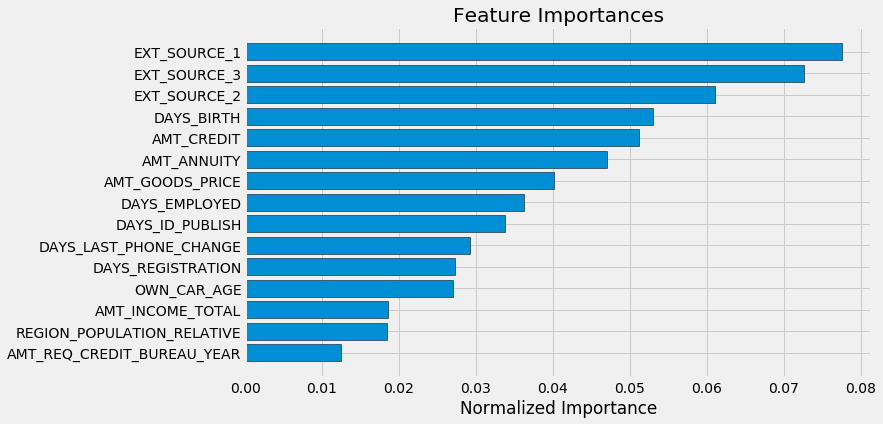

In [11]:
fi_sorted = plot_feature_importances(fi)

In [12]:
submission.to_csv('../../output/control.csv', index = False)

__The control scores 0.745 when submitted to the competition.__

### Test One

Let's conduct the first test. We will just need to pass in the data to the function, which does most of the work for us.

In [ ]:
submission_raw, fi_raw, metrics_raw = model(train, test)

In [ ]:
metrics_raw

Based on these numbers, the engineered features perform better than the control case. However, we will have to submit the predictions to the leaderboard before we can say if this better validation performance transfers to the testing data. 

In [ ]:
fi_raw_sorted = plot_feature_importances(fi_raw)

Examining the feature improtances, it looks as if a few of the feature we constructed are among the most important. Let's find the percentage of the top 100 most important features that we made in this notebook. However, rather than just compare to the original features, we need to compare to the _one-hot encoded_ original features. These are already recorded for us in `fi` (from the original data). 

In [ ]:
top_100 = list(fi_raw_sorted['feature'])[:100]
new_features = [x for x in top_100 if x not in list(fi['feature'])]

print('%% of Top 100 Features created from the bureau data = %d.00' % len(new_features))

Over half of the top 100 features were made by us! That should give us confidence that all the hard work we did was worthwhile. 

In [ ]:
submission_raw.to_csv('test_one.csv', index = False)

__Test one scores 0.759 when submitted to the competition.__

### Test Two

That was easy, so let's do another run! Same as before but with the highly collinear variables removed. 

In [ ]:
submission_corrs, fi_corrs, metrics_corr = model(train_corrs_removed, test_corrs_removed)

In [ ]:
metrics_corr

These results are better than the control, but slightly lower than the raw features. 

In [ ]:
fi_corrs_sorted = plot_feature_importances(fi_corrs)

In [ ]:
submission_corrs.to_csv('test_two.csv', index = False)

__Test Two scores 0.753 when submitted to the competition.__

# Results

After all that work, we can say that including the extra information did improve performance! The model is definitely not optimized to our data, but we still had a noticeable improvement over the original dataset when using the calculated features. Let's officially summarize the performances:

| __Experiment__ | __Train AUC__ | __Validation AUC__ | __Test AUC__  |
|------------|-------|------------|-------|
| __Control__    | 0.815 | 0.760      | 0.745 |
| __Test One__   | 0.837 | 0.767      | 0.759 |
| __Test Two__   | 0.826 | 0.765      | 0.753 |


(Note that these scores may change from run to run of the notebook. I have not observed that the general ordering changes however.)

All of our hard work translates to a small improvement of 0.014 ROC AUC over the original testing data. Removing the highly collinear variables slightly decreases performance so we will want to consider a different method for feature selection. Moreover, we can say that some of the features we built are among the most important as judged by the model. 

In a competition such as this, even an improvement of this size is enough to move us up 100s of spots on the leaderboard. By making numerous small improvements such as in this notebook, we can gradually achieve better and better performance. I encourage others to use the results here to make their own improvements, and I will continue to document the steps I take to help others. 

## Next Steps

Going forward, we can now use the functions we developed in this notebook on the other datasets. There are still 4 other data files to use in our model! In the next notebook, we will incorporate the information from these other data files (which contain information on previous loans at Home Credit) into our training data. Then we can build the same model and run more experiments to determine the effect of our feature engineering. There is plenty more work to be done in this competition, and plenty more gains in performance to be had! I'll see you in the next notebook.